In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../data/historic_demand_2009_2023.csv")

In [4]:
elec_df = df[192_816: 194_788]

In [5]:
elec_df = elec_df[["settlement_date", "embedded_wind_generation"]]

In [6]:
elec_df.head()

,settlement_date,embedded_wind_generation
192816,2020-01-01,1244
192817,2020-01-01,1188
192818,2020-01-01,1156
192819,2020-01-01,1125
192820,2020-01-01,1106


In [7]:
wind_df = pd.read_csv("../data/Hull_2020-01-01_to_2020-02-10.csv")
wind_df["windgust"].tail()


979    53.6
980    49.7
981    57.8
982    65.0
983    78.4
Name: windgust, dtype: float64

In [8]:
wind_df = wind_df[["datetime","windgust", "windspeed"]]

In [9]:
wind_df['windgust'] = wind_df['windgust'].fillna(0)

In [10]:
wind_df.head()

,datetime,windgust,windspeed
0,2020-01-01T00:00:00,0.0,1.7
1,2020-01-01T01:00:00,0.0,4.1
2,2020-01-01T02:00:00,0.0,4.0
3,2020-01-01T03:00:00,0.0,4.3
4,2020-01-01T04:00:00,0.0,4.3


In [11]:
wind_df_long = pd.DataFrame(np.repeat(wind_df.values, 2, axis=0))
wind_df_long.columns = wind_df.columns
wind_df_long.head()

,datetime,windgust,windspeed
0,2020-01-01T00:00:00,0.0,1.7
1,2020-01-01T00:00:00,0.0,1.7
2,2020-01-01T01:00:00,0.0,4.1
3,2020-01-01T01:00:00,0.0,4.1
4,2020-01-01T02:00:00,0.0,4.0


In [12]:
wind_df_long["windspeed"] = wind_df_long["windspeed"]*120

In [13]:
wind_df_long.head()

,datetime,windgust,windspeed
0,2020-01-01T00:00:00,0.0,204.0
1,2020-01-01T00:00:00,0.0,204.0
2,2020-01-01T01:00:00,0.0,492.0
3,2020-01-01T01:00:00,0.0,492.0
4,2020-01-01T02:00:00,0.0,480.0


In [14]:
test_begin_point = 1475

In [15]:
endog_train = elec_df["embedded_wind_generation"][:test_begin_point].to_numpy()
endog_train = np.array(endog_train, dtype=float)
len(endog_train)

1475

In [16]:
endog_test_df = elec_df["embedded_wind_generation"][test_begin_point:-4]
endog_test = np.array(endog_test_df, dtype=float)
len(endog_test)

493

In [17]:
exog_train = wind_df_long["windspeed"][:test_begin_point].to_numpy()
exog_train = np.array(exog_train, dtype=float)
exog_train = exog_train
len(exog_train)

1475

In [18]:
exog_test = wind_df_long["windspeed"][test_begin_point:].to_numpy()
exog_test = np.array(exog_test, dtype=float)
exog_test = exog_test
len(exog_test)

493

In [19]:
# import pmdarima as pm
# sarimax = pm.auto_arima(elec_df["embedded_wind_generation"], exogenous=wind_df_long["windspeed"],
#                            start_p=0, start_q=0,
#                            test='adf',
#                            max_p=2, max_q=2, m=12,
#                            start_P=0, seasonal=True,
#                            d=None, D=1, trace=True,
#                            suppress_warnings=True, 
#                            stepwise=True)

In [20]:
SARIMAX(endog=endog_train,
        exog=exog_train,
        order=(2, 0, 2),seasonal_order=(2,1,0,12)
       )

In [21]:
mod = SARIMAX(endog_train, order=(1, 0, 0),seasonal_order=(2,1,0,12), exog=(exog_train), alpha=0.02, beta=0.02)
mod = mod.fit(maxiter=300)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.00196D+00    |proj g|=  9.76121D-01


 This problem is unconstrained.



At iterate    5    f=  6.73851D+00    |proj g|=  3.36847D-02

At iterate   10    f=  6.72218D+00    |proj g|=  5.48596D-03

At iterate   15    f=  6.72134D+00    |proj g|=  1.92019D-03

At iterate   20    f=  6.63091D+00    |proj g|=  2.00834D-01

At iterate   25    f=  6.61391D+00    |proj g|=  5.48399D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     35      1     0     0   8.311D-05   6.614D+00
  F =   6.6139137621572148     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [22]:
print(mod.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1475
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -9755.523
Date:                            Wed, 22 Mar 2023   AIC                          19521.046
Time:                                    15:13:24   BIC                          19547.487
Sample:                                         0   HQIC                         19530.908
                                           - 1475                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0014      0.013     -0.114      0.909      -0.026       0.023
ar.L1          1.0000      0.004   

In [23]:
# Forecast
forecast_length = 100
results = mod.get_forecast(forecast_length, exog = exog_test[:forecast_length], alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()

In [24]:
forecast

array([3913.23116319, 3894.95009947, 3877.77116235, 3903.7471607 ,
       3928.85863898, 3937.47292696, 3947.08456288, 3942.5067396 ,
       3936.81022136, 3960.04515466, 3984.41030248, 4015.49770953,
       4038.65809959, 4072.27443301, 4105.88150451, 4178.75651907,
       4250.40049629, 4303.3804856 , 4356.89975033, 4379.46362534,
       4400.12160611, 4438.54138655, 4479.98390823, 4497.85890022,
       4506.10419418, 4522.85078673, 4539.54415448, 4604.19665259,
       4667.24500857, 4698.39675815, 4730.66514077, 4731.91176614,
       4733.42864653, 4753.1693585 , 4774.24334907, 4786.08397602,
       4784.90792662, 4794.57259658, 4804.84088073, 4858.60294236,
       4911.39869449, 4942.22297287, 4973.12585405, 4979.46817876,
       4984.19772958, 5011.65834052, 5039.84599188, 5058.28412468,
       5068.07483459, 5089.95556135, 5109.96900525, 5174.1828794 ,
       5236.34250001, 5273.77854544, 5312.68786986, 5323.23196007,
       5332.36216476, 5361.78367203, 5392.31848825, 5410.77342

In [25]:
def plot_forecast(fc, train, test, windspeed, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    wind_series = pd.Series(windspeed)
    wind_series = wind_series
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training generation', color='black')
    plt.plot(test, label='actual generation', color='black', ls='--')
    plt.plot(fc_series, label='forecast generation', color='orange')
    plt.plot(wind_series, label='wind speed in hull', color='blue')
    plt.xlim(1200,test_begin_point+200)
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [26]:
endog_test = pd.DataFrame(endog_test)
endog_test.index = endog_test.index + test_begin_point

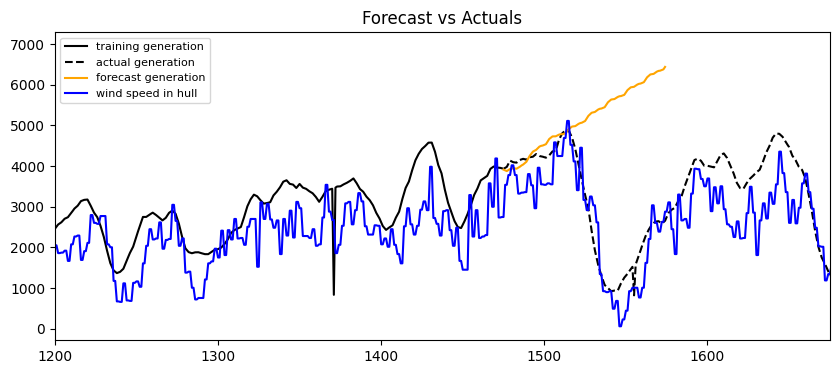

In [27]:
forecast_recons = pd.Series(forecast, index=endog_test.index[:forecast_length])

plot_forecast(forecast_recons,endog_train, endog_test, wind_df_long["windspeed"])